# Lista 02 - Tópicos III

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('breast-cancer-wisconsin.csv', header=None, delimiter=';')

# some values of column 6 are = '?', i replace this values with 1
data[6] = data[6].apply(lambda x: 1 if x == '?' else int(x))

data.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


## Separating data in training and test

In [3]:
from sklearn.model_selection import train_test_split

X = data.iloc[:, 1:10].values
y = data.iloc[:, -1].values
# 0 for benign, 1 for malignamt
y = np.where(y == 2, 0, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

## Multi-layer perceptron implementation

In [4]:
class MLP(object):
    def __init__(self, f_act='sigmoid', n_hidden=15, l2=0.0, epochs=20, lr=0.001, shuffle=True, minibatch_size=1, seed=None):
        self.f_act = f_act
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        # Lambda value for L2-regularization.
        self.l2 = l2
        self.epochs = epochs
        self.lr = lr
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
    
    # activation_function (sigmoid)
    def _sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-np.clip(z, -250, 250)))
        
    # activation_function (tanh)
    def _tanh(self, z):
        return np.tanh(z)
        
    def _forward(self, X):
        # net input of hidden layer
        z_hidden = np.dot(X, self.weight_hidden) + self.b_hidden
        
        # activation of hidden layer
        if self.f_act == 'tanh':
            activation_hidden = self._tanh(z_hidden)
        else:
            activation_hidden = self._sigmoid(z_hidden)
        
        # net input of out layer
        z_out = np.dot(activation_hidden, self.weight_out) + self.b_out
        
        # activation of output layer
        if self.f_act == 'arctan':
            activation_out = self._tanh(z_out)
        else:
            activation_out = self._sigmoid(z_out)
        
        return z_hidden, activation_hidden, z_out, activation_out
        
    def _compute_cost(self, y_enc, output):
        l2_term = self.l2 * (np.sum(self.weight_hidden ** 2.0) + np.sum(self.weight_out ** 2.0))
        
        term_1 = -y_enc * np.log(output)
        term_2 = (1.0 - y_enc) * np.log(1.0 - output)
        cost = np.sum(term_1 - term_2) + l2_term
        
        return cost
    
    def predict(self, X):
        # only z_out matters
        z_out = self._forward(X)[2]
        y_pred = np.argmax(z_out, axis=1)
        return y_pred
    
    def _onehot(self, y, n_classes):
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T
    
    def fit(self, X_train, y_train, X_test, y_test):
        n_output = np.unique(y_train).shape[0]
        n_features = X_train.shape[1]
        
        self.b_hidden = np.zeros(self.n_hidden)
        self.weight_hidden = self.random.normal(loc=0.0, scale=0.1, size=(n_features, self.n_hidden))
        
        self.b_out = np.zeros(n_output)
        self.weight_out = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden, n_output))
    
        self.eval_ = {'cost': [], 'train_acc': [], 'test_acc': []}
        
        # new y encoded
        y_train_enc = self._onehot(y_train, n_output)
        
        for i in range(self.epochs):
            indices = np.arange(X_train.shape[0])
            
            if self.shuffle:
                self.random.shuffle(indices)
            
            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                
                z_hidden, activation_hidden, z_out, activation_out = self._forward(X_train[batch_idx])

                # backpropragation starts here
                
                sigma_out = activation_out - y_train_enc[batch_idx]
                
                # when using sigmoid as activation function
                if self.f_act == 'tanh':
                    activation_derivate_hidden = (1.0 - (activation_hidden ** 2))
                else:
                    # sigmoid
                    activation_derivate_hidden = activation_hidden * (1.0 - activation_hidden)
                
                sigma_hidden = np.dot(sigma_out, self.weight_out.T) * activation_derivate_hidden
                
                grad_weight_hidden = np.dot(X_train[batch_idx].T, sigma_hidden)
                grad_b_hidden = np.sum(sigma_hidden, axis=0)
                
                grad_weight_out = np.dot(activation_hidden.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)
                
                # Regularization and weight updates
                
                # in hidden layer
                delta_weight_hidden = (grad_weight_hidden + self.l2 * self.weight_hidden)
                delta_b_hidden = grad_b_hidden # bias (not regularized)
                self.weight_hidden -= self.lr * delta_weight_hidden
                self.b_hidden -= self.lr * delta_b_hidden

                # in output layer
                delta_weight_out = (grad_weight_out + self.l2 * self.weight_out)
                delta_b_out = grad_b_out  # same here
                self.weight_out -= self.lr * delta_weight_out
                self.b_out -= self.lr * delta_b_out
            
            # evaluation starts here
            
            # for each epoch, after backpropagation ends evaluate training
            z_hidden, activation_hidden, z_out, activation_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc, output=activation_out)
            
            y_train_predicted = self.predict(X_train)
            y_test_predicted = self.predict(X_test)
            
            # accuracy for train and test
            train_acc = ((np.sum(y_train == y_train_predicted)).astype(np.float) /
             X_train.shape[0])
            test_acc = ((np.sum(y_test == y_test_predicted)).astype(np.float) /
                         X_test.shape[0])
            
            
            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['test_acc'].append(test_acc)
    
        return self

## Report (item 1)

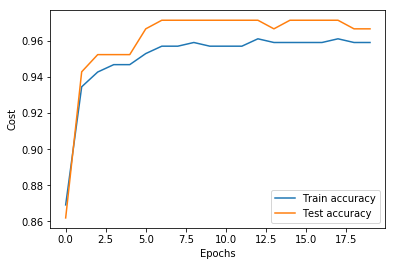

In [5]:
mlp = MLP(n_hidden=100, 
          l2=0.01, 
          epochs=20, 
          lr=0.001,
          shuffle=True,
          seed=7)

mlp.fit(X_train, y_train, X_test, y_test)

plt.plot(range(mlp.epochs), mlp.eval_['train_acc'], label='Train accuracy')
plt.plot(range(mlp.epochs), mlp.eval_['test_acc'], label='Test accuracy')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.legend()
plt.show()

## Sigmoid x TanH (item 2)

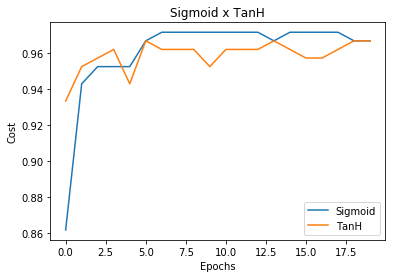

In [6]:
mlp_tanh = MLP(n_hidden=100, 
          f_act='tanh',
          l2=0.01, 
          epochs=20, 
          lr=0.001,
          shuffle=True,
          seed=7)

mlp_tanh.fit(X_train, y_train, X_test, y_test)

plt.plot(range(mlp.epochs), mlp.eval_['test_acc'], label='Sigmoid')
plt.plot(range(mlp_tanh.epochs), mlp_tanh.eval_['test_acc'], label='TanH')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.title('Sigmoid x TanH')
plt.legend()
plt.show()

## Backpropagation calc w_6 (item 3)

$$\frac{\partial net_{o1}}{\partial w_6} = 1 * out_{h2} * w_{6}^{(1-1)} + 0 + 0 = out_{h2} = 0.5968844378$$

$$\frac{\partial E_{total}}{\partial w_6} = \frac{\partial E_{total}}{\partial out_{o1}} *
  \frac{\partial out_{o1}}{\partial net_{o1}} * \frac{\partial net_{o1}}{\partial w_5}$$
  
$$\frac{\partial E_{total}}{\partial w_6} = 0.74136507 * 0.186815602 * 0.5968844378 = 0.0826676362$$

$$w_6^+ = w_6 - \eta * \frac{\partial E_{total}}{\partial w_6} = 0.45 - 0.5*0.0826676362 = 0.40866618198$$